In [1]:
%matplotlib inline 
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'

In [2]:
import nawrapper as nw
import pymaster as nmt
import numpy as np
import matplotlib.pyplot as plt
import healpy as hp

# File Loading

We specify the filepaths here.

In [3]:
map_dir = '/tigress/zequnl/cmb/data/planck/maps/PR2/frequencyMaps'
mask_dir = '/tigress/zequnl/cmb/data/planck/maps/PR2/maskMaps/'
beam_dir = '/tigress/zequnl/cmb/software/PSpipe/project/Planck/planck_beam/'
nside = 2048
lmax = 2508
freq1 = '143'
freq2 = '143'

# now the specific combination m1 x m2 we want to do here
beam_filename = f'{beam_dir}/beam_probably_used_in_2015_likelihood_{freq2}hm1x{freq1}hm2.dat.dat'
mfile_1 = f'{map_dir}/HFI_SkyMap_{freq1}_2048_R2.02_halfmission-{1}.fits'
mfile_2 = f'{map_dir}/HFI_SkyMap_{freq2}_2048_R2.02_halfmission-{2}.fits'
maskfile1 = f'{mask_dir}/COM_Mask_Likelihood-temperature-{freq1}_2048_R2.00.fits'
maskfile2 = f'{mask_dir}/COM_Mask_Likelihood-temperature-{freq1}_2048_R2.00.fits'

Next, we load in the beams, and then initialize a `namap` with the beams, maps and masks. 

In [4]:
beam = nw.read_beam(beam_filename)
mask1 = hp.read_map(maskfile1, verbose=False)
mask2 = hp.read_map(maskfile2, verbose=False)
m1_map_I = nw.maptools.sub_mono_di(
    hp.read_map(mfile_1, field=0, verbose=False), 
    mask1, nside)  * 1e6
m2_map_I = nw.maptools.sub_mono_di(
    hp.read_map(mfile_2, field=0, verbose=False), 
    mask2, nside)  * 1e6

/home/zequnl/.conda/envs/ps/lib/python3.7/site-packages/healpy/fitsfunc.py:372: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


The Planck maps have some missing pixels, we remove them.

In [5]:
def load_bad_pix(freq, split):
    mfile = f'{map_dir}/HFI_SkyMap_{freq}_2048_R2.02_halfmission-{split}.fits'
    hits = hp.read_map(mfile, field=3, verbose=False)
    bad = (hits == 0)
    return bad

badpix1 = load_bad_pix(freq1, 1)
badpix2 = load_bad_pix(freq2, 2)

m1_map_I[badpix1] = 0.0
m2_map_I[badpix2] = 0.0
mask1[badpix1] = 0.0
mask2[badpix2] = 0.0

In [6]:
m1 = nw.namap_healpy(
    maps=m1_map_I, masks=mask1, beams=beam, unpixwin=True)

m2 = nw.namap_healpy(
    maps=m2_map_I, masks=mask2, beams=beam, unpixwin=True)

Assuming the same mask for both I and QU.
Assuming the same beams for both I and QU.
Creating a healpix namap. temperature: True, polarization: False
Including the healpix pixel window function.
Computing spherical harmonics.

Assuming the same mask for both I and QU.
Assuming the same beams for both I and QU.
Creating a healpix namap. temperature: True, polarization: False
Including the healpix pixel window function.
Computing spherical harmonics.



We load in the beams.

Next, we compute the mode coupling matrix from the first two fields. We will reuse this for all spectra calculations.

In [7]:
bins = nw.get_unbinned_bins(lmax)
mc = nw.mode_coupling(m1, m2, bins)

In [30]:
Cl = nw.compute_spectra(m1, m2, mc=mc)
Cb = nw.bin_spec_dict(Cl, binleft, binright, lmax)

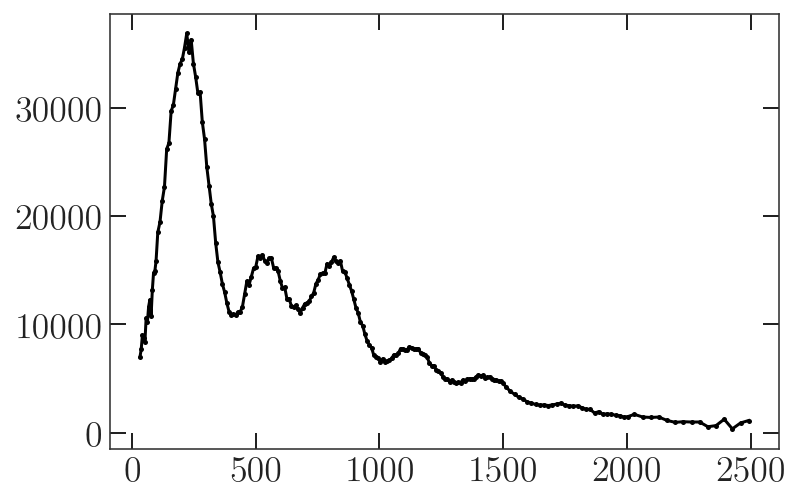

In [31]:
plt.plot(Cb['ell'], Cb['TT'] * Cb['ell']**2)

In [32]:
binleft, binright = np.genfromtxt(
    '/tigress/zequnl/cmb/software/PSpipe/project/Planck/planck_spectra/binused.dat',
    unpack=True, usecols=(0,1), dtype=((int), (int)))

Text(0.5, 1.0, 'TT 143x143')

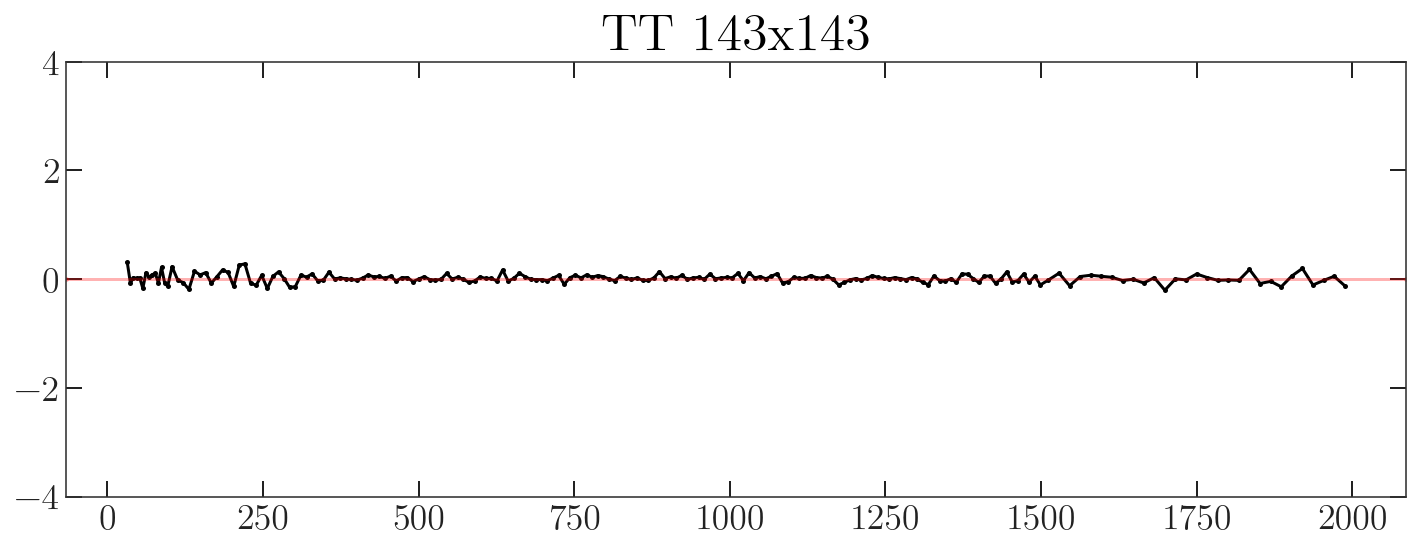

In [33]:
fig, ax = plt.subplots(1,1,figsize=(12,4))
spec = 'TT'
lb = Cb['ell']
lmin_,lmax_,l_ref,cl_ref,error_ref=np.loadtxt(
    '/tigress/zequnl/cmb/software/PSpipe/project/Planck/planck_spectra/spectra_' 
    + f'{spec}_{freq1}x{freq2}' + '.dat',unpack=True)
dl_ref_fac = l_ref*(l_ref+1)/(2*np.pi)
ref_filt = np.in1d(lb, l_ref)
ax.plot(l_ref, (Cb[spec][ref_filt] - (cl_ref)) / (error_ref), 'k.-', label=spec)
ax.axhline(0, color='red', alpha=0.3)
ax.set_ylim(-4,4)
ax.set_title(f'{spec} {freq1}x{freq2}')